# Vision Transformer usando transfer learning


## Se importan las librerías necesarias

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from tensorflow.keras.utils import  set_random_seed
from keras.layers import Dense, Dropout, BatchNormalization,Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
import os
!pip install vit_keras
!pip install tensorflow_addons
from vit_keras import vit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=a03c4d14e6fd06c9c987f1a781c773bc14de4a9fdc90547a224e5221a3b6fec5
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




## Se cargan los datos desde el almacenamiento interno

In [3]:
# Funcion usada para dividir el conjunto de datos en entrenamiento, validación y test
# splitfolders.ratio(dataset_path, output= destination_path, seed=1337, ratio=(0.7, 0.2,0.1))

dataset_path = # escribir aqui la ruta del dataset

# parametros
model_name = "A_VIT_extra"
width = 224
height = 224
batch_size = 32
n_epochs = 15

# modificar generadores para incluir data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                zoom_range=0.3,
                                width_shift_range=0.4,
                                height_shift_range=0.4,
                                shear_range=0,
                                horizontal_flip=True,
                                vertical_flip=False,
                                fill_mode="nearest"
                               )

test_datagen = ImageDataGenerator(rescale=1./255
                                )

train_generator = train_datagen.flow_from_directory(
        dataset_path+'/train',
        target_size=(width, height),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        seed = 202)

validation_generator = test_datagen.flow_from_directory(
        dataset_path+'/val',
        target_size=(width, height),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        seed = 202)

test_generator = test_datagen.flow_from_directory(
        dataset_path+'/test',
        target_size=(width, height),
        batch_size=batch_size,
        shuffle=False,
        class_mode="categorical")


Found 7326 images belonging to 20 classes.
Found 2110 images belonging to 20 classes.
Found 1079 images belonging to 20 classes.


## Ejemplos de entrenamiento

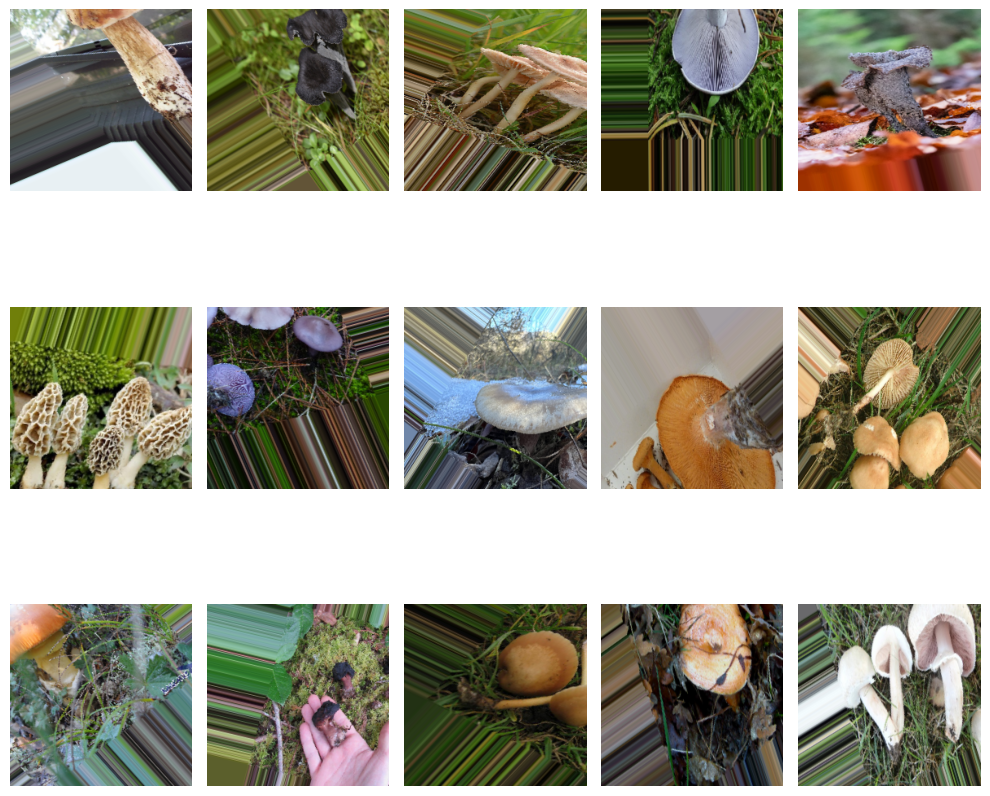

In [4]:
# Obtiene un batch de imágenes generadas
images = [train_generator[0][0][i] for i in range(16)]

# Muestra las imágenes generadas
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Mecanismo de Early Stopping
Se define un mecanismo de Early Stopping (checkpoint) que se encarga de almacenar aquel modelo con mejor valor de loss para el conjunto de validación. De esta forma se consigue encontrar el número de ciclos que optimiza el aprendizaje del vision transformer

In [5]:
parent_dir = # escribir aqui el directorio de destino de los modelos
path = os.path.join(parent_dir, model_name)
if not os.path.exists(path):
        os.mkdir(path)
results_path = parent_dir+"/"+model_name+"/"

checkpoint = ModelCheckpoint(results_path+"best_model.h5", monitor='val_loss', verbose=1, save_best_only=True)

## Definición del modelo de Vision Transformer

In [6]:
num_classes = 20
vit_model = vit.vit_b16(
        image_size = width,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

top_dropout_rate = 0.25
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(top_dropout_rate),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(top_dropout_rate),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(top_dropout_rate),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ],
    name = 'vision_transformer')

model.summary()

347502902/347502902 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                

## Compilación del modelo

In [7]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])


## Entrenamiento del modelo de ViT

In [8]:
historico= model.fit(
        train_generator,
        epochs=n_epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint]
        )

Epoch 1/15
229/229 [==============================] - ETA: 0s - loss: 1.8904 - categorical_accuracy: 0.4566 
Epoch 1: val_loss improved from inf to 0.46040, saving model to /content/drive/MyDrive/TFG/models/TL_VIT_aug_def/best_model.h5
229/229 [==============================] - 4419s 19s/step - loss: 1.8904 - categorical_accuracy: 0.4566 - val_loss: 0.4604 - val_categorical_accuracy: 0.8645
Epoch 2/15
229/229 [==============================] - ETA: 0s - loss: 0.7054 - categorical_accuracy: 0.7928
Epoch 2: val_loss improved from 0.46040 to 0.28619, saving model to /content/drive/MyDrive/TFG/models/TL_VIT_aug_def/best_model.h5
229/229 [==============================] - 554s 2s/step - loss: 0.7054 - categorical_accuracy: 0.7928 - val_loss: 0.2862 - val_categorical_accuracy: 0.9137
Epoch 3/15
229/229 [==============================] - ETA: 0s - loss: 0.5158 - categorical_accuracy: 0.8501
Epoch 3: val_loss improved from 0.28619 to 0.26207, saving model to /content/drive/MyDrive/TFG/models/T

## Graficos de evolución

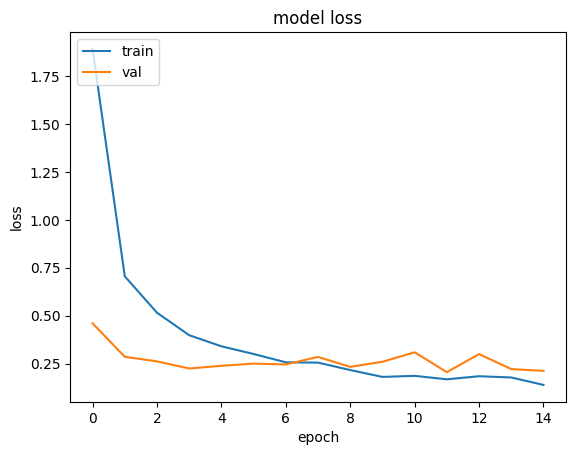

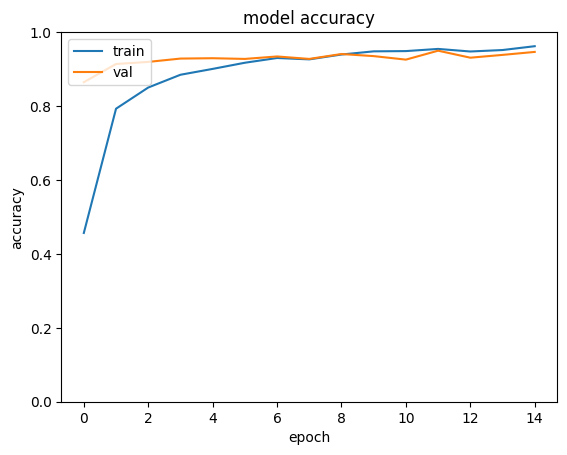

In [9]:
#Gráfica del loss del modelo
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(results_path+"loss_graph.png")
plt.show()

#Gráfica de accuracy del modelo
plt.plot(historico.history['categorical_accuracy'])
plt.plot(historico.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.savefig(results_path+"accuracy_graph.png")
plt.show()

## Valores de loss y accuracy en conjuntos de entrenamiento, validación y test del mejor modelo
Se recupera el ciclo con mejor valor para el conjunto de validación obtenido con el mecanismo de Checkpoint

In [10]:
ciclo_final=np.where(historico.history['val_loss'] == np.min(historico.history['val_loss']))
ciclo_final = ciclo_final[0][0]

train_loss = historico.history['loss'][ciclo_final]
train_acc = historico.history['categorical_accuracy'][ciclo_final]

val_loss = historico.history['val_loss'][ciclo_final]
val_acc = historico.history['val_categorical_accuracy'][ciclo_final]

print("Mejor ciclo: ", ciclo_final)
print('Training loss:', train_loss)
print('Training categorical accuracy:', train_acc)
print('Validation loss:', val_loss)
print('Validation categorical accuracy:', val_acc)
# Se carga el archivo almacenado por el metodo de checkpoint
#model_cnn.save(results_path+'best_model.h5')
saved_model = load_model(results_path+'best_model.h5')

evaluacion_cnn = saved_model.evaluate(test_generator)
test_loss = evaluacion_cnn[0]
test_acc = evaluacion_cnn[1]
print(f'Test results - Loss: {test_loss} - Accuracy: {test_acc}')

# Almacenamiento de los resultados en un archivo csv
resultados_csv = # escribir aqui la ruta del archivo csv 
with open(resultados_csv, "a") as f1:
        f1.write(model_name+","+str(train_loss)+","+str(train_acc)+","+str(val_loss)+","+str(val_acc)+","+str(test_loss)+","+str(test_acc)+","+str(ciclo_final)+"\n")
f1.close()

Mejor ciclo:  11
Training loss: 0.16885872185230255
Training categorical accuracy: 0.9545454382896423
Validation loss: 0.20597386360168457
Validation categorical accuracy: 0.9497630596160889
34/34 [==============================] - 504s 15s/step - loss: 0.1963 - categorical_accuracy: 0.9555
Test results - Loss: 0.1962994635105133 - Accuracy: 0.9555143713951111


## Muestra y almacenamiento de la matriz de confusion y el classification report

34/34 [==============================] - 40s 1s/step


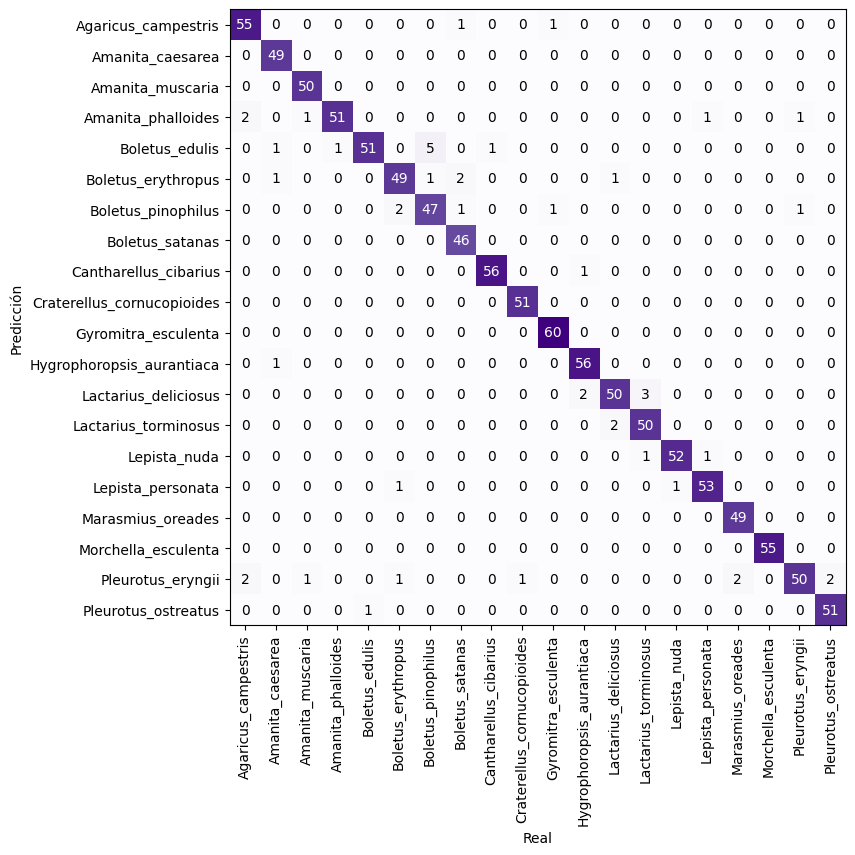

                            precision    recall  f1-score   support

       Agaricus_campestris       0.96      0.93      0.95        59
          Amanita_caesarea       1.00      0.94      0.97        52
          Amanita_muscaria       1.00      0.96      0.98        52
        Amanita_phalloides       0.91      0.98      0.94        52
            Boletus_edulis       0.86      0.98      0.92        52
        Boletus_erythropus       0.91      0.92      0.92        53
        Boletus_pinophilus       0.90      0.89      0.90        53
           Boletus_satanas       1.00      0.92      0.96        50
     Cantharellus_cibarius       0.98      0.98      0.98        57
Craterellus_cornucopioides       1.00      0.98      0.99        52
       Gyromitra_esculenta       1.00      0.97      0.98        62
 Hygrophoropsis_aurantiaca       0.98      0.95      0.97        59
      Lactarius_deliciosus       0.91      0.94      0.93        53
      Lactarius_torminosus       0.96      0.93

In [11]:
# obtenemos las predicciones realizadas por el modelo
test_pred = saved_model.predict(test_generator)
class_pred =  np.argmax(test_pred, axis=1)

# se calcula la matriz de confusion
conf_matrix = np.transpose(confusion_matrix(test_generator.labels, class_pred))

class_names = list(test_generator.class_indices.keys())

report = classification_report(test_generator.labels, class_pred, target_names=class_names)

# almacenamos una imagen de la matriz de confusion
labels = list(test_generator.class_indices.keys())
ig, axis = plt.subplots(figsize=(8, 8))
im = axis.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Purples)

axis.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=labels, yticklabels=labels,
       xlabel='Real', ylabel='Predicción')

axis.set_xticklabels(labels, rotation=90, fontsize=10)
axis.set_yticklabels(labels, fontsize=10)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axis.text(j, i, format(conf_matrix[i, j], 'd'),ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')
plt.savefig(results_path+'confusion_matrix.png', bbox_inches='tight')
plt.show()

print(report)

# se guarda el classification report
with open(results_path+'classification_report.txt', 'w') as f:
    f.write(report)
f.close()
# se guarda la matriz de confusion
np.savetxt(results_path +'matrizConf_cnn.txt', conf_matrix, fmt='%-3d')
# se guardan los pesos
saved_model.save_weights(results_path +'pesos_cnn.h5')